## IMPORT LIBRARIES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk

## DATA LOADING & PREPROCESSING

In [40]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# =====================
print("Loading and preprocessing data...")

# Load dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data
true_labels = newsgroups.target
target_names = newsgroups.target_names

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize and lowercase
    words = text.lower().split()
    # Lemmatize and filter
    words = [lemmatizer.lemmatize(w) for w in words
             if w not in stop_words and len(w) > 2]
    return ' '.join(words)

# Preprocess all documents
corpus = [preprocess(doc) for doc in documents]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading and preprocessing data...


## FEATURE EXTRACTION

In [27]:
print("Extracting features...")

# TF-IDF for K-means
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# BoW for LDA
count_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
bow_matrix = count_vectorizer.fit_transform(corpus)

Extracting features...


### K-MEANS CLUSTERING

In [28]:
print("Running K-means clustering...")
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(tfidf_matrix)

Running K-means clustering...


### LDA TOPIC MODELING

In [29]:
print("Running LDA topic modeling...")
lda = LatentDirichletAllocation(n_components=20, random_state=42, learning_method='online')
lda.fit(bow_matrix)
lda_labels = lda.transform(bow_matrix).argmax(axis=1)

Running LDA topic modeling...


## VISUALIZATIONS

* K-MEANS VISUALIZATIONS



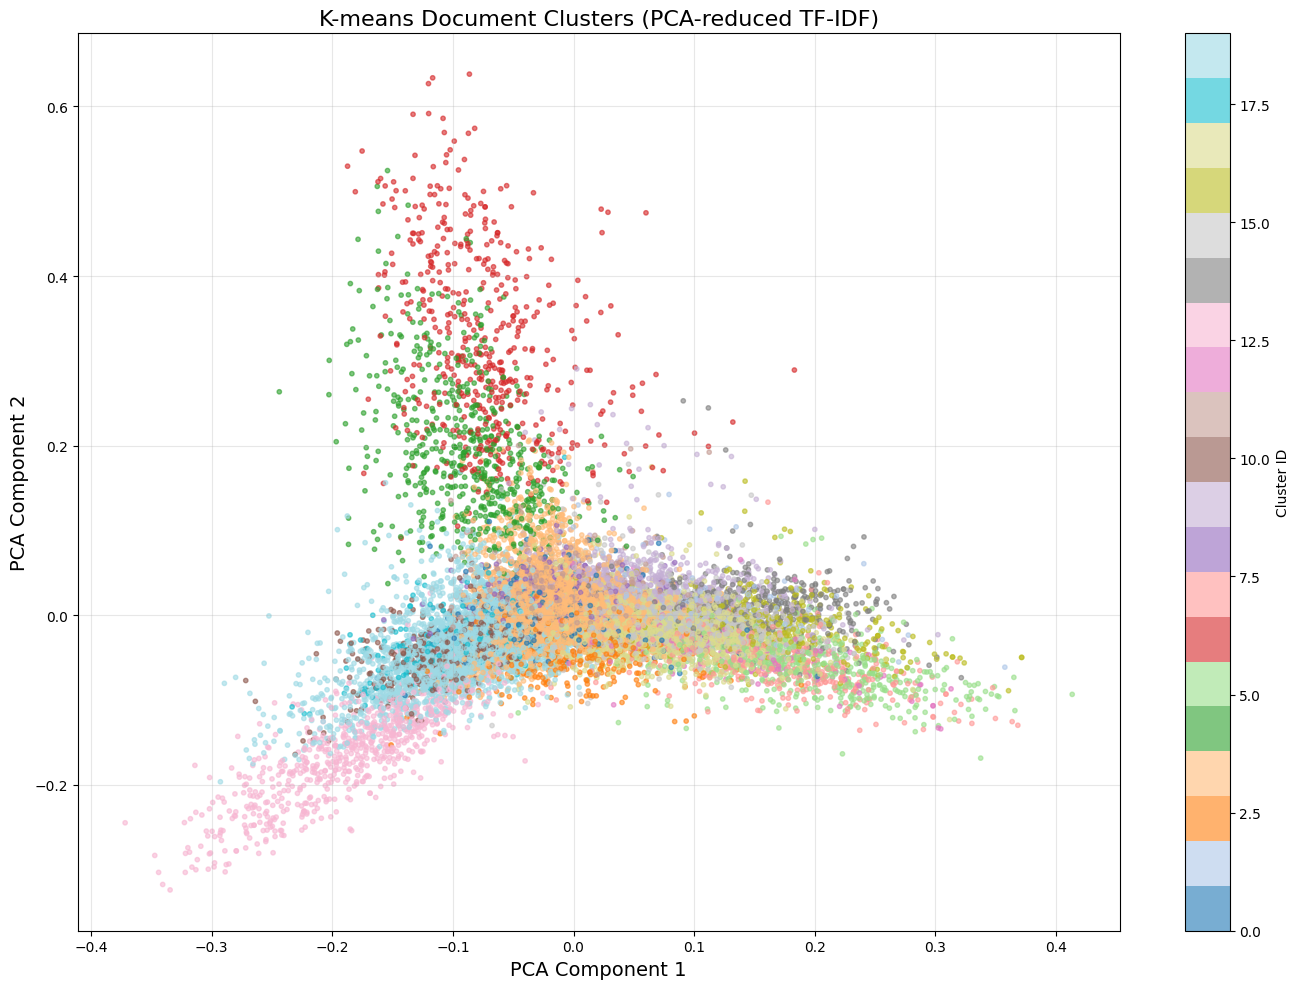

In [30]:
# PCA for 2D visualization
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(14, 10))
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1],
            c=kmeans_labels, cmap='tab20', alpha=0.6, s=10)
plt.title('K-means Document Clusters (PCA-reduced TF-IDF)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.colorbar(label='Cluster ID')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_pca.png')
plt.show()

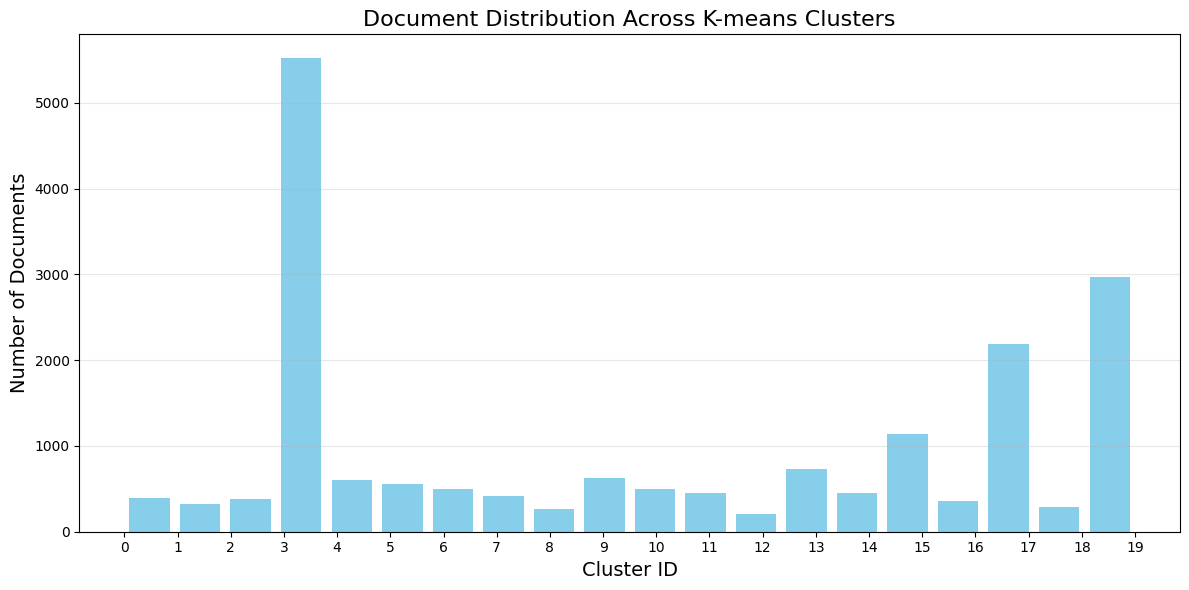

In [31]:
# Cluster size distribution
plt.figure(figsize=(12, 6))
plt.hist(kmeans_labels, bins=20, rwidth=0.8, color='skyblue')
plt.title('Document Distribution Across K-means Clusters', fontsize=16)
plt.xlabel('Cluster ID', fontsize=14)
plt.ylabel('Number of Documents', fontsize=14)
plt.xticks(range(20))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_cluster_sizes.png')
plt.show()

* LDA VISUALIZATIONS

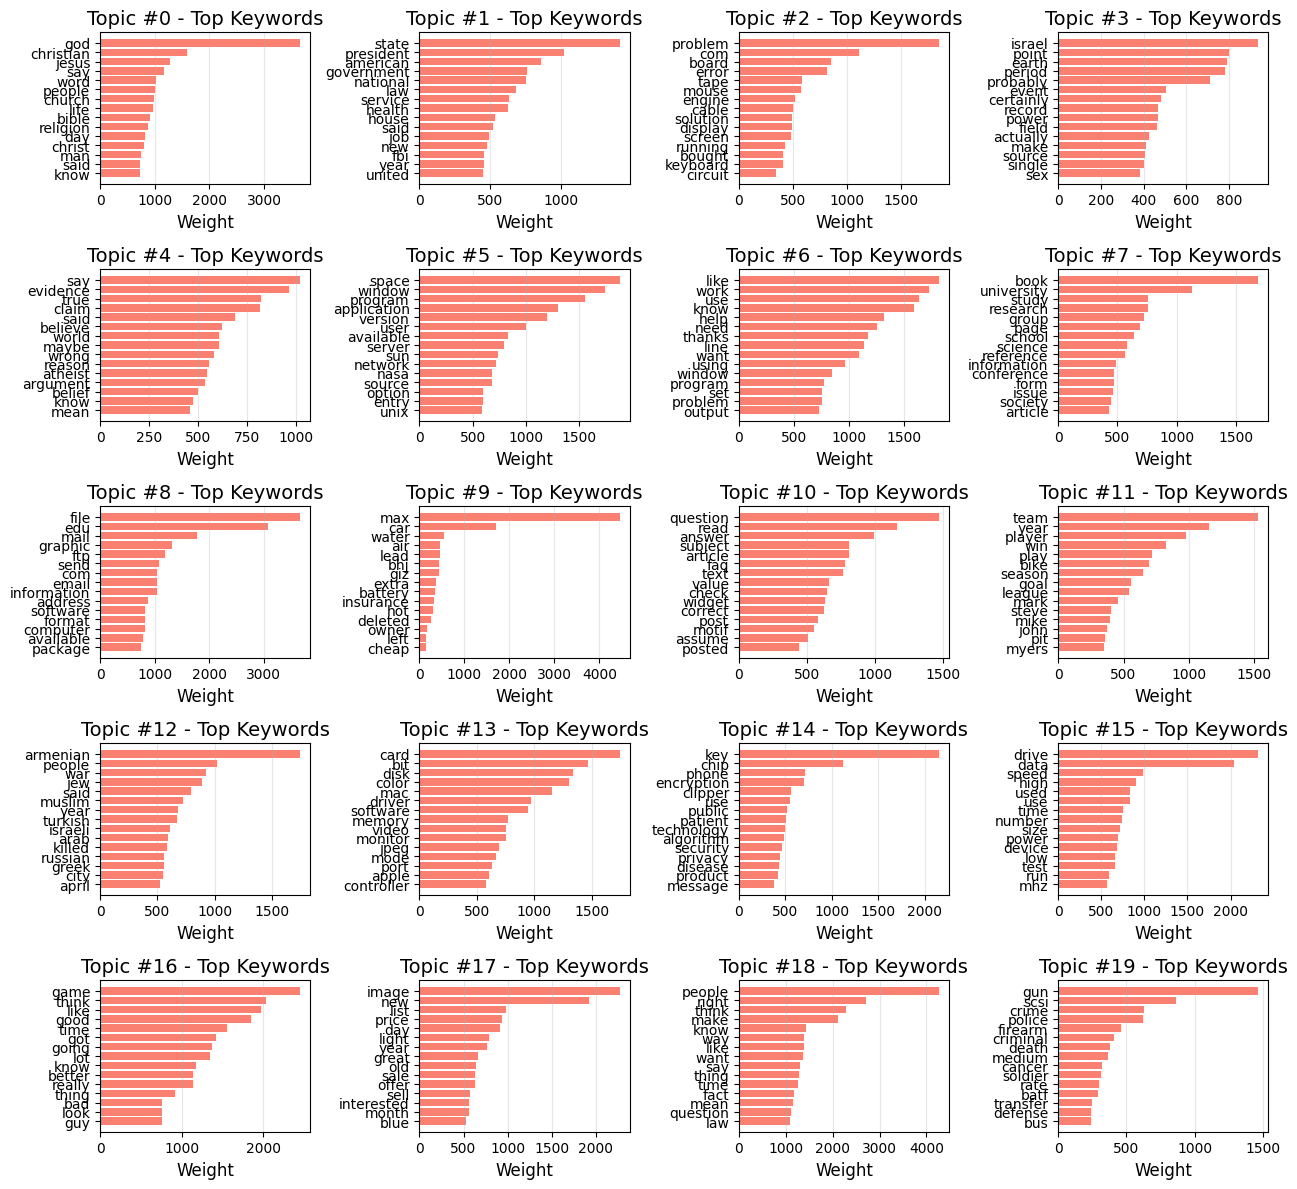

In [35]:
# Get feature names
feature_names = count_vectorizer.get_feature_names_out()

# Top words for first 6 topics
plt.figure(figsize=(13, 12))
for topic_idx in range(20):
    plt.subplot(5, 4, topic_idx+1)
    top_words_idx = lda.components_[topic_idx].argsort()[-15:]
    top_words = [feature_names[i] for i in top_words_idx]
    weights = lda.components_[topic_idx][top_words_idx]

    plt.barh(top_words, weights, color='salmon')
    plt.title(f'Topic #{topic_idx} - Top Keywords', fontsize=14)
    plt.xlabel('Weight', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('lda_topics.png')
plt.show()

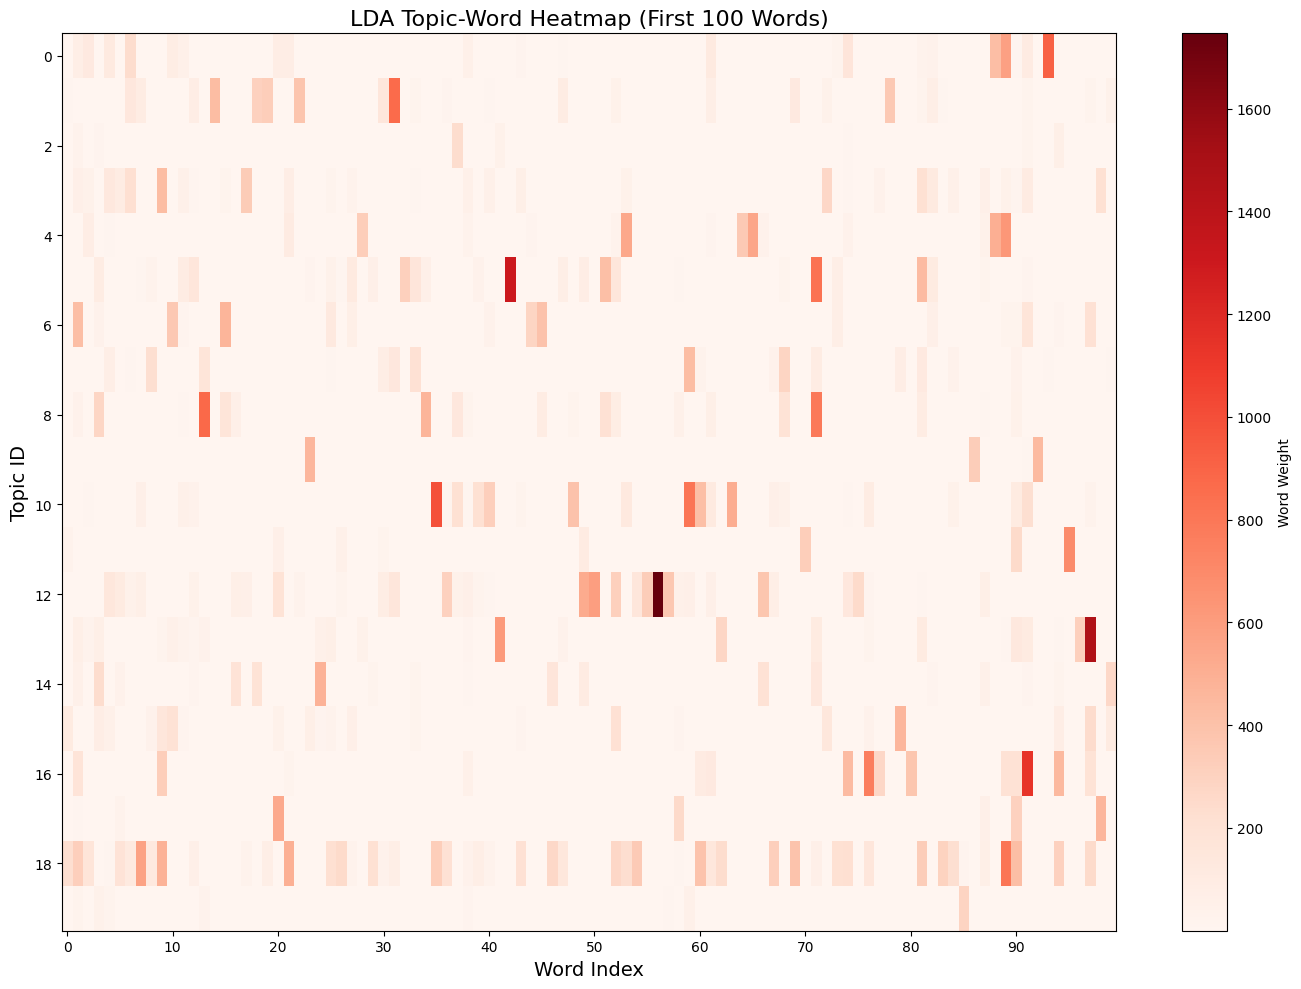

In [33]:
# Topic-word heatmap (for first 100 words)
plt.figure(figsize=(14, 10))
plt.imshow(lda.components_[:, :100], cmap='Reds', aspect='auto')
plt.colorbar(label='Word Weight')
plt.title('LDA Topic-Word Heatmap (First 100 Words)', fontsize=16)
plt.xlabel('Word Index', fontsize=14)
plt.ylabel('Topic ID', fontsize=14)
plt.xticks(np.arange(0, 100, 10))
plt.yticks(range(0, 20, 2))
plt.tight_layout()
plt.savefig('lda_heatmap.png')
plt.show()

## GROUND TRUTH COMPARISON

In [36]:
# Calculate metrics
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
lda_ari = adjusted_rand_score(true_labels, lda_labels)

kmeans_nmi = normalized_mutual_info_score(true_labels, kmeans_labels)
lda_nmi = normalized_mutual_info_score(true_labels, lda_labels)

print("\n=== Evaluation Metrics ===")
print(f"K-means Adjusted Rand Index (ARI): {kmeans_ari:.4f}")
print(f"LDA Adjusted Rand Index (ARI): {lda_ari:.4f}")
print(f"K-means Normalized Mutual Info (NMI): {kmeans_nmi:.4f}")
print(f"LDA Normalized Mutual Info (NMI): {lda_nmi:.4f}")


=== Evaluation Metrics ===
K-means Adjusted Rand Index (ARI): 0.0743
LDA Adjusted Rand Index (ARI): 0.0807
K-means Normalized Mutual Info (NMI): 0.3159
LDA Normalized Mutual Info (NMI): 0.1934


## CONFUSION MATRICES

* K-means confusion matrix

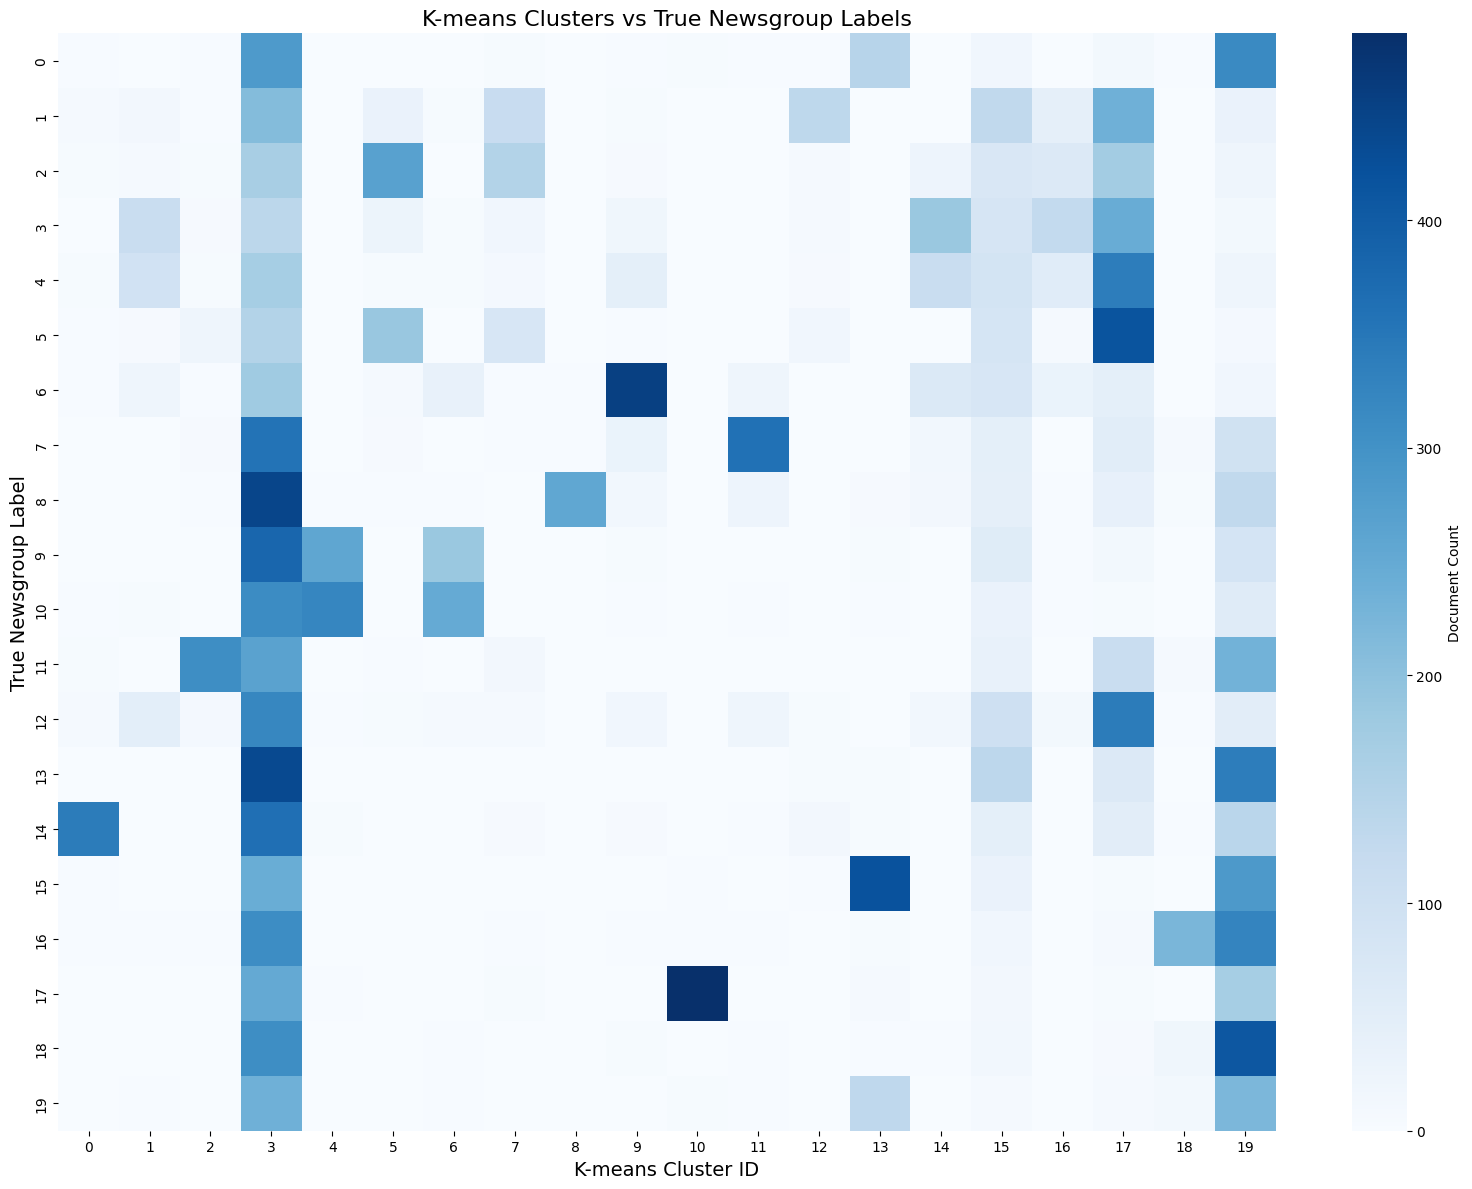

In [37]:
plt.figure(figsize=(16, 12))
conf_matrix = confusion_matrix(true_labels, kmeans_labels)
sns.heatmap(conf_matrix, cmap='Blues', annot=False, cbar_kws={'label': 'Document Count'})
plt.title('K-means Clusters vs True Newsgroup Labels', fontsize=16)
plt.xlabel('K-means Cluster ID', fontsize=14)
plt.ylabel('True Newsgroup Label', fontsize=14)
plt.tight_layout()
plt.savefig('kmeans_confusion.png')
plt.show()

* LDA confusion matrix

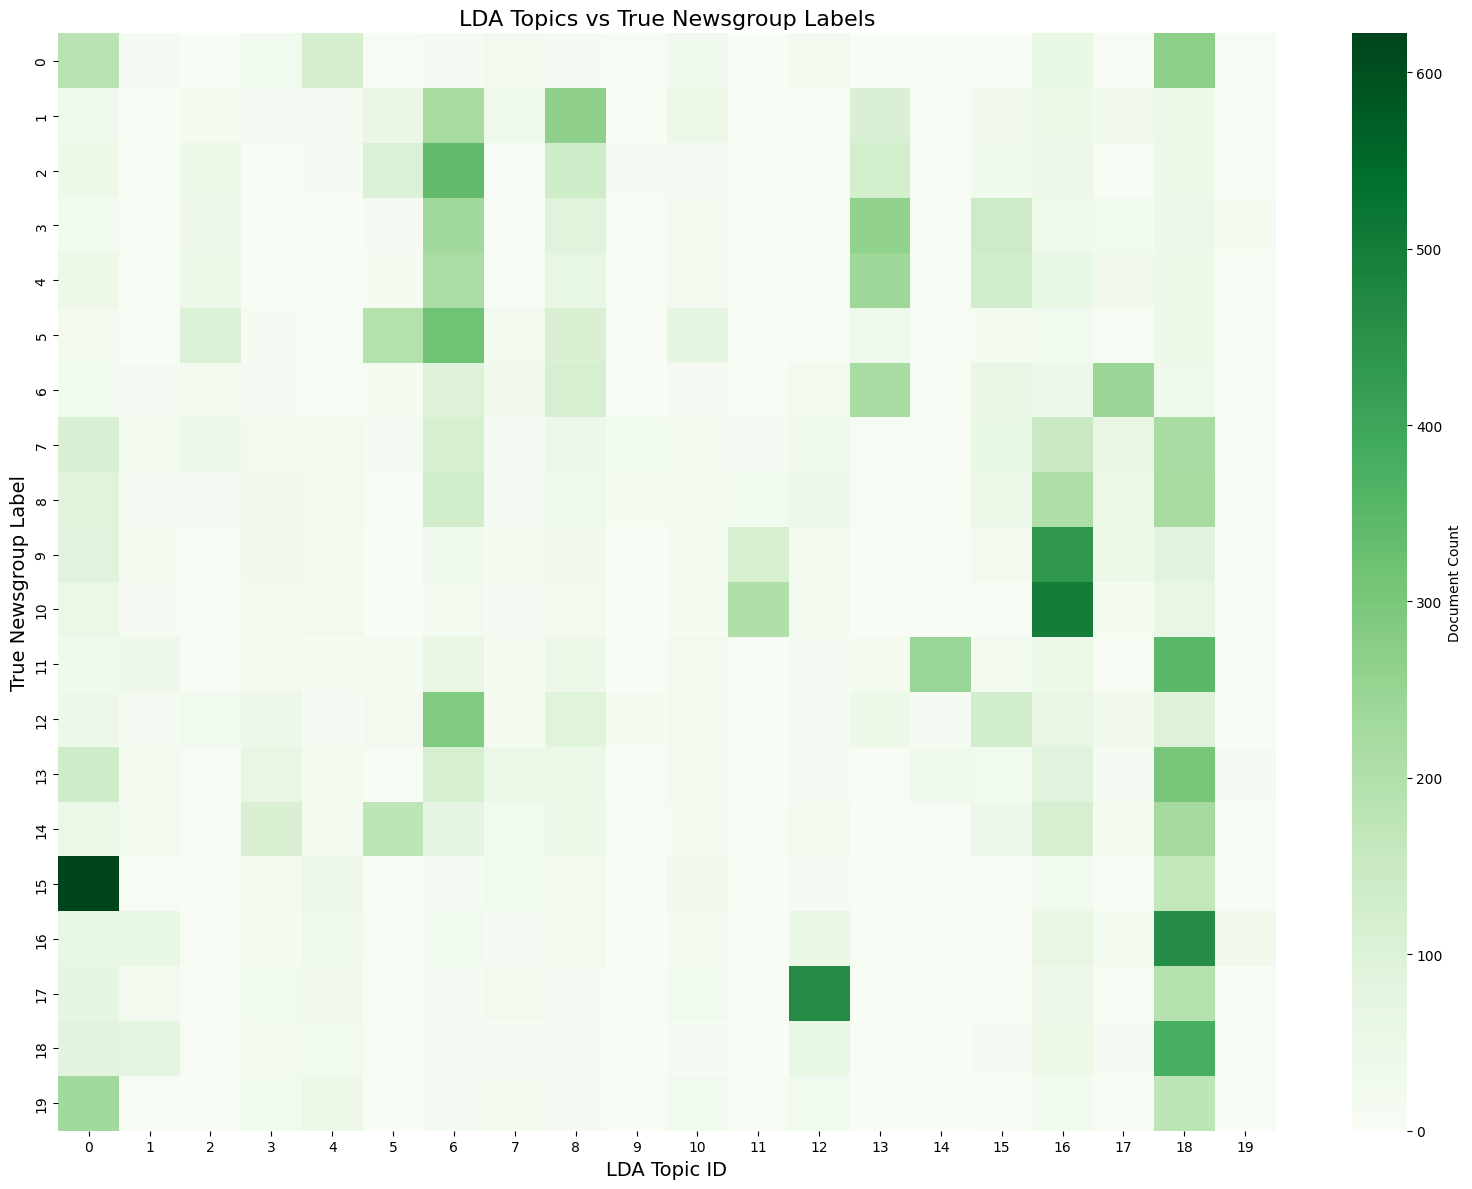

In [38]:
plt.figure(figsize=(16, 12))
lda_matrix = confusion_matrix(true_labels, lda_labels)
sns.heatmap(lda_matrix, cmap='Greens', annot=False, cbar_kws={'label': 'Document Count'})
plt.title('LDA Topics vs True Newsgroup Labels', fontsize=16)
plt.xlabel('LDA Topic ID', fontsize=14)
plt.ylabel('True Newsgroup Label', fontsize=14)
plt.tight_layout()
plt.savefig('lda_confusion.png')
plt.show()

## TOPIC-LABEL ALIGNMENT

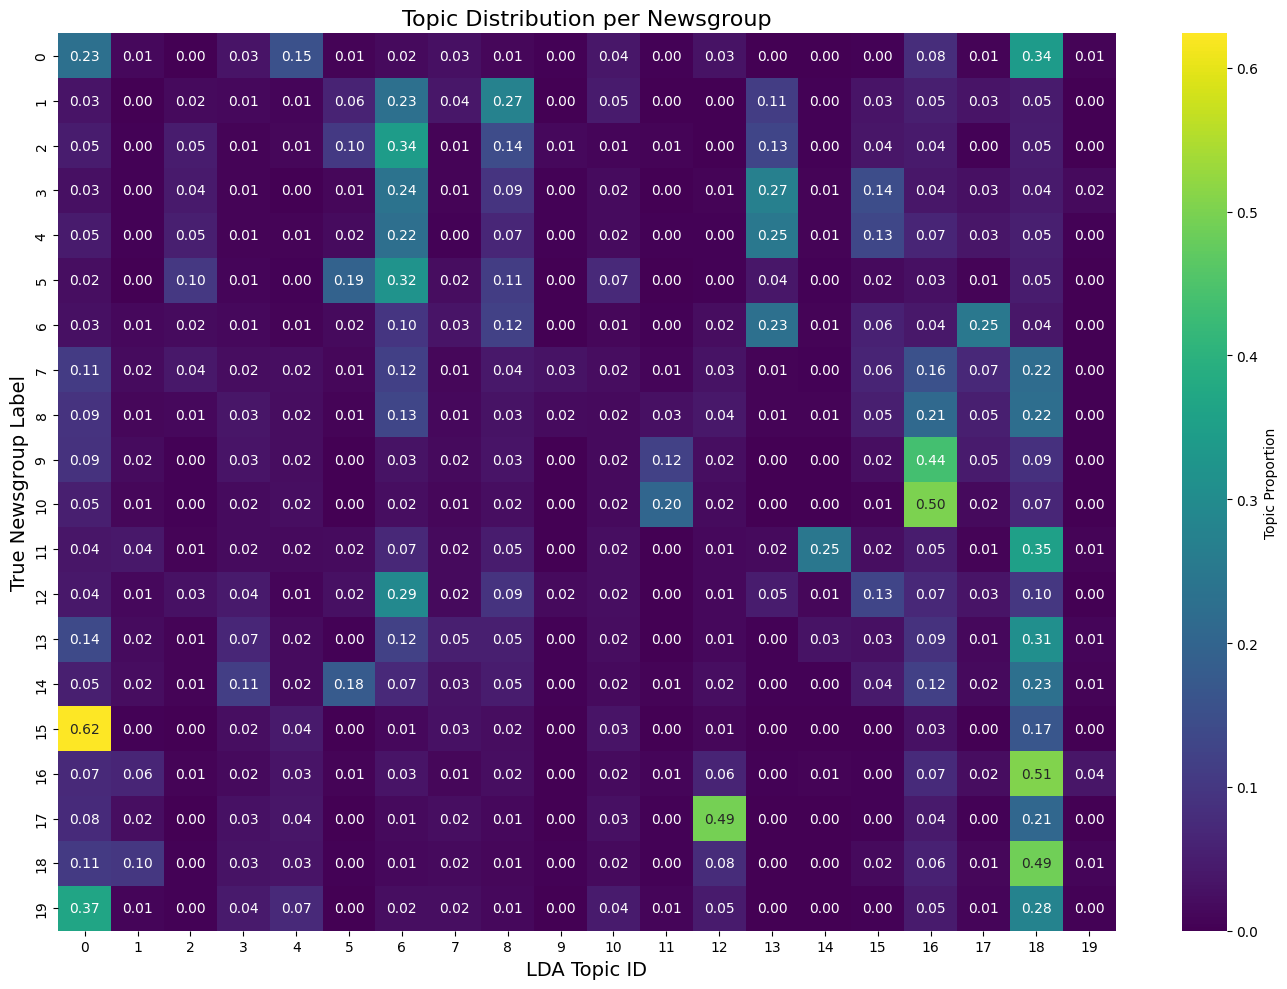

Analysis complete!


In [39]:
# Find dominant topic for each newsgroup
topic_dominance = np.zeros((20, 20))
for true_label in range(20):
    topic_counts = np.bincount(lda_labels[true_labels == true_label], minlength=20)
    topic_dominance[true_label] = topic_counts / topic_counts.sum()

plt.figure(figsize=(14, 10))
sns.heatmap(topic_dominance, cmap='viridis', annot=True, fmt='.2f',
            cbar_kws={'label': 'Topic Proportion'})
plt.title('Topic Distribution per Newsgroup', fontsize=16)
plt.xlabel('LDA Topic ID', fontsize=14)
plt.ylabel('True Newsgroup Label', fontsize=14)
plt.tight_layout()
plt.savefig('topic_newsgroup_alignment.png')
plt.show()

print("Analysis complete!")